# **Trabajo Práctico 2 : Críticas cinematográficas**

# Grupo 33
#Integrantes:
1.   Mendoza Hernandez, Sabrina Scarlet (108524)
2.   Valeriani, Matias Gabriel (108570)
3.   Jang, Lucas (109151)


#Importar librerias

In [ ]:
#datos
import numpy as np
import pandas as pd

#Plots
import matplotlib.pyplot as plt
import seaborn as sns

#Metricas
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix, classification_report , f1_score, make_scorer, roc_auc_score
from sklearn.model_selection import GridSearchCV, train_test_split, RandomizedSearchCV, StratifiedKFold
#nltk
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud

#Bag of word
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

#Clasificadores
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

#Exportar e importar modelo
import joblib
from urllib.request import urlretrieve

#String
import string

#TF y Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout, LSTM, Embedding, Bidirectional
from keras.utils.vis_utils import plot_model
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

#Funciones auxiliares

* Función auxiliar *metricas(y_pred, y_test)* para mostrar la matriz de confusión con sus respectivas métricas encontradas.

In [ ]:
def metricas(y_pred,y_test):

  print(classification_report(y_test,y_pred))

  cm = confusion_matrix(y_test,y_pred)
  sns.heatmap(cm, cmap='YlOrRd',annot=True,fmt='g')
  plt.xlabel('Predicted')
  plt.ylabel('True')

* Función auxiliar *predecir_y_exportar_a_csv_con_BN(bn, x_test, f1_score_train)* para predecir el mejor clasificador de Bayes Naive y luego exportarlo a csv con sus respectivos parametros y métrica de F1 Score obtenida con el conjunto de entrenamiento.

In [ ]:
def predecir_y_exportar_a_csv_con_BN(bn, x_test, f1_score_train):

    y_pred = bn.predict(x_test)
    df_submission = pd.DataFrame({'id': criticas_test['ID'], 'sentimiento': y_pred})

    params = bn.get_params()
    alpha = params['alpha']
    fit_prior = params['fit_prior']

    df_submission.to_csv(f"pred_BN-alpha_{alpha}-fit_prior_{fit_prior}-f1_{round(f1_score_train, 4)}.csv", index=False)

* Función auxiliar *exportar_BN(bn, f1_score_train)* para exportar el modelo de Bayes Naive.

In [ ]:
def exportar_BN(bn, f1_score_train):
    params = bn.get_params()
    alpha = params['alpha']
    fit_prior = params['fit_prior']

    joblib.dump(bn, f'BN-alpha_{alpha}-fit_prior_{fit_prior}-f1_{round(f1_score_train, 4)}.joblib')

* Función auxiliar *exportar_RF(rf, f1_score_train)* para exportar el modelo Random Forest con los mejores hiperparametros encontrado mediante Randomized Search.

In [ ]:
def exportar_RF(rf, f1_score_train):
    params = rf.get_params()

    max_depth = params['max_depth']
    min_samples_split = params['min_samples_split']
    min_samples_leaf = params['min_samples_leaf']
    n_estimators = params['n_estimators']
    criterion = params['criterion']

    joblib.dump(rf, f'RF-max_depth_{max_depth}-min_samples_split_{min_samples_split}-min_samples_leaf_{min_samples_leaf}-n_estimators_{n_estimators}-criterion_{criterion}-f1_{round(f1_score_train, 4)}.joblib')


* Función auxiliar *exportar_XGB(xgb, f1_score_train)* para exportar el modelo XGBoost con los mejores hiperparametros encontrado mediante Randomized Search.

In [ ]:
def exportar_XGB(xgb, f1_score_train):
    params = xgb.get_params()

    n_estimators = params['n_estimators']
    max_depth = params['max_depth']
    learning_rate = params['learning_rate']
    colsample_bytree = params['colsample_bytree']

    joblib.dump(xgb, f'XGB-n_estimators_{n_estimators}-learning_rate_{learning_rate}-max_depth_{max_depth}-f1_{round(f1_score_train, 4)}.joblib')


* Definimos la métrica de F1-score, la utilizaremos para el uso de redes neuronales.

In [ ]:
def f1_score_metric(y_true, y_pred):
    y_pred = tf.round(y_pred)
    f1 = 2 * tf.reduce_sum(y_true * y_pred) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + tf.keras.backend.epsilon())
    return f1

* Función auxiliar *exportar_ensamble(ensamble, f1_score_train)* para exportar el modelo de esnamble Voting.

In [ ]:
def exportar_ensamble(ensamble, f1_score_train):
    classifier1 = LSVC
    classifier2 = log_clf
    classifier3 = SGDC
    classifier4 = best_xgb
    classifier5 = best_rf
    joblib.dump(ensamble, f'Ensamble-LSVC-log_clf-SGDC-XGB-RF-f1_{round(f1_score_train, 4)}.joblib')

#Lectura del dataset

## Dataframe train

In [ ]:
df = pd.read_csv('https://drive.google.com/uc?export=download&id=1ZOaijjfu4NGe-MYR_biv09G71Z1AW0VF')
criticas = df.copy()
print(f"La cantidad de filas son {len(criticas)} y la cantidad de columnas son {len(criticas.columns)}\n")
print(criticas.columns)

La cantidad de filas son 50000 y la cantidad de columnas son 3

Index(['ID', 'review_es', 'sentimiento'], dtype='object')


In [ ]:
criticas.head(10)

,ID,review_es,sentimiento
0,0,Uno de los otros críticos ha mencionado que de...,positivo
1,1,Una pequeña pequeña producción.La técnica de f...,positivo
2,2,Pensé que esta era una manera maravillosa de p...,positivo
3,3,"Básicamente, hay una familia donde un niño peq...",negativo
4,4,"El ""amor en el tiempo"" de Petter Mattei es una...",positivo
5,5,Probablemente mi película favorita de todos lo...,positivo
6,6,Seguro que me gustaría ver una resurrección de...,positivo
7,7,"Este espectáculo fue una idea increíble, fresc...",negativo
8,8,Alentados por los comentarios positivos sobre ...,negativo
9,9,"Si te gusta la risa original desgarradora, te ...",positivo


In [ ]:
criticas.iloc[7, 1]

'Este espectáculo fue una idea increíble, fresca e innovadora en los años 70 cuando se emitió por primera vez.Los primeros 7 u 8 años fueron brillantes, pero las cosas se dejaron después de eso.Para 1990, el espectáculo ya no era realmente divertido, y continúa su descenso a la completa pérdida de tiempo que es hoy. Es verdaderamente vergonzosa hasta qué punto ha caído este espectáculo.La escritura es dolorosamente mala, las actuaciones son casi tan malas, si no para el respiro levemente entretenido de los hosts de invitados, este programa probablemente no estaría en el aire.Me resulta tan difícil creer que el mismo creador que seleccionó a mano el reparto original también eligió la banda de hacks que siguieron.¿Cómo se puede reconocer ese brillo y luego verlos adecuados para reemplazarlo con tal mediocridad?Sentí que debía darle a 2 estrellas del respeto por el elenco original que hizo que este programa fuera un gran éxito.Como es ahora, el espectáculo es simplemente horrible.No puedo

* Mostramos la cantidad de criticas que corresponden a cada valor del target *sentimiento*

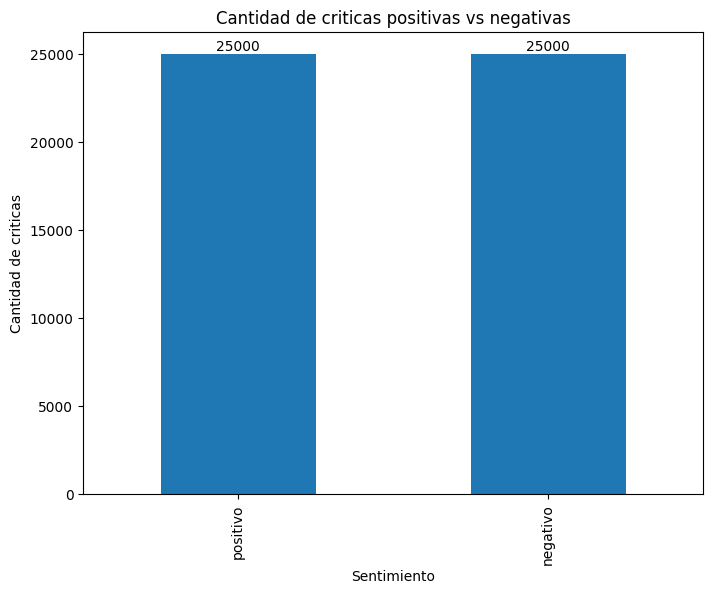

In [ ]:
cant_criticas = criticas['sentimiento'].value_counts()

plt.figure(figsize=(8, 6))
ax = cant_criticas.plot(kind='bar')

for i, v in enumerate(cant_criticas):
    ax.text(i, v, str(v), ha='center', va='bottom')


plt.title('Cantidad de criticas positivas vs negativas')
plt.xlabel('Sentimiento')
plt.ylabel('Cantidad de criticas')
plt.show()

##Preprocesamiento

* Previo a realizar el preprocesamiento de las críticas, se observan que hay simbolos tales como parentesis, comillas, comas de manera muy frecuente. Ademas hay varias stopwords en ingles (como "the" en la lista que se muestra, podria haber mas) y español (tales como "la, el, una, los, de,..."). Para eso realizaremos una analisis exhaustivo de dichas palabras y mas funciones que ayuden a dejar el dataframe de manera óptima para la utilizacion de distintos clasificadores.

In [ ]:
from collections import Counter
nltk.download('stopwords')
nltk.download('punkt')

all_text = ' '.join(criticas['review_es'])

tokens = word_tokenize(all_text.lower())

word_counts = Counter(tokens)

sorted_words = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)

top_words = word_counts.most_common(50)

for word, count in top_words:
    print(f'{word}: {count}')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


,: 703504
de: 659721
la: 394650
.: 385550
que: 375932
y: 295661
en: 272518
el: 230517
a: 215454
un: 184568
es: 177436
una: 168759
los: 149242
película: 145656
no: 136584
se: 128086
para: 96306
lo: 92755
con: 90805
las: 90066
su: 87568
por: 85526
esta: 77426
``: 75255
como: 73466
): 70912
(: 69481
pero: 68848
'': 68265
más: 57418
del: 53623
the: 51673
!: 43673
al: 40093
está: 37277
me: 34893
fue: 33898
?: 32758
si: 31914
o: 30502
este: 29515
películas: 28183
son: 28044
solo: 27638
sus: 27164
muy: 26901
sin: 26255
ser: 25927
esto: 25619
cuando: 25425


* El trabajo del preprocesamiento de las criticas correspondientes a la variable *review_es* lo haremos en una funcion en la que convertiremos el texto a minuscula, reemplazaremos los singos de puntuacion por espacios en blanco. Posteriormente haremos una tokenizacion del texto y eliminacion de las stopwords (vimos que ademas eliminando las stopwords en ingles mejoraban el rendimientode los clasifcadores, ya que encontramos palabras en ginels como *the*). Como ultimos pasos utilizamos la lematización de las palabras para reducirlas a su forma base o "lemma". Finalmente creamos una nueva variable con la union de los tokens preprocesados.

In [ ]:
nltk.download('wordnet')

def preprocess_text(text):
    text = text.lower()

    for punctuation in string.punctuation:
        text = text.replace(punctuation, ' ')

    tokens = word_tokenize(text)

    stopwords_spanish = stopwords.words('spanish')

    words_to_remove = ['no', 'como', 'más', 'pero', 'sí', 'porque', 'esta', 'muy', 'sin', 'también', 'todo', 'ni', 'mucho', 'nada', 'muchos', 'poco']

    for word in words_to_remove:
        stopwords_spanish.remove(word)

    stop_words_spanish = set(stopwords_spanish)
    stop_words_english = set(stopwords.words('english'))
    stop_words = stop_words_english.union(stop_words_spanish)
    tokens = [token for token in tokens if token not in stop_words]

    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    preprocessed_text = ' '.join(tokens)

    return preprocessed_text

criticas['preprocessed_text'] = criticas['review_es'].apply(preprocess_text)
print(criticas.head())


[nltk_data] Downloading package wordnet to /root/nltk_data...


   ID                                          review_es sentimiento  \
0   0  Uno de los otros críticos ha mencionado que de...    positivo   
1   1  Una pequeña pequeña producción.La técnica de f...    positivo   
2   2  Pensé que esta era una manera maravillosa de p...    positivo   
3   3  Básicamente, hay una familia donde un niño peq...    negativo   
4   4  El "amor en el tiempo" de Petter Mattei es una...    positivo   

                                   preprocessed_text  
0  críticos mencionado después ver solo 1 oz epis...  
1  pequeña pequeña producción técnica filmación m...  
2  pensé esta manera maravillosa pasar tiempo fin...  
3  básicamente familia niño pequeño jake piensa z...  
4  amor tiempo petter mattei película visualmente...  


* Calculamos la frecuencia de las palabras y creamos un WordCloud con las palabras más utilizadas luego de realizar el preprocesamiento.

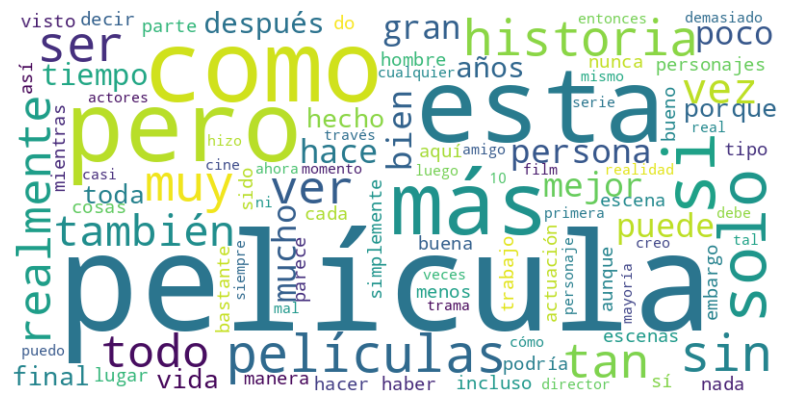

In [ ]:
frecuencia_palabras = criticas['preprocessed_text'].str.split(expand=True).stack().value_counts()

wordcloud = WordCloud(width=800, height=400, max_words=100, background_color='white').generate_from_frequencies(frecuencia_palabras)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Dataframe test

In [ ]:
df_test = pd.read_csv("https://drive.google.com/uc?export=download&id=1qHANkYWrwEZK_E12Of7cCaNc5CWIkvWV")
criticas_test = df_test.copy()

In [ ]:
criticas_test['preprocessed_text'] = criticas_test['review_es'].apply(preprocess_text)

print(criticas_test.head())

      ID                                          review_es  \
0  60000  La mayor virtud de esta película es su existen...   
1  60001  No soy un experto cinéfilo, pero pocas veces m...   
2  60002  Si no eres un incondicional del humor estilo T...   
3  60003  No sé qué está pasando, si la gente se deja ll...   
4  60004  Pero cuando amanece,y me quedo solo,siento en ...   

                                   preprocessed_text  
0  mayor virtud esta película existencia hecho po...  
1  experto cinéfilo pero pocas veces tan juego sa...  
2  si incondicional humor estilo tele 5 si termin...  
3  sé pasando si gente deja llevar modas si verda...  
4  pero amanece quedo solo siento fondoun mar vac...  


#Construir la matriz TF-IDF y dividir los datos en conjuntos de entrenamiento y prueba

Realizamos una representación vectorial de texto basada en el esquema de TF-IDF (Term Frequency-Inverse Document Frequency). Esto ajusta el modelo a los datos de texto y transforma los textos en una matriz TF-IDF. La matriz resultante es una representación numérica de los textos en la que cada fila corresponde a un texto y cada columna representa un término ponderado por su frecuencia y su inversa en el conjunto de documentos.

In [ ]:
tfidf = TfidfVectorizer()
preprocessed_texts = criticas['preprocessed_text']
tfidf_matrix = tfidf.fit_transform(preprocessed_texts)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix, criticas['sentimiento'], test_size=0.2, random_state=42)

#Modelo de clasificación Bayes Naïve

El modelo de clasificación Bayes Naïve (Naive Bayes) es un algoritmo de aprendizaje automático que se basa en el teorema de Bayes para realizar clasificación de texto. Dado un conjunto de características (palabras) en un documento, el modelo calcula la probabilidad de cada clase y selecciona la clase con la mayor probabilidad como la predicción final.

* Mostramos como sería el clasificador con los parámetros predeterminados, previamente a buscar los mejores hiperparámetros.

F1-score: 0.8589782194118238
              precision    recall  f1-score   support

    negativo       0.85      0.87      0.86      4961
    positivo       0.87      0.85      0.86      5039

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



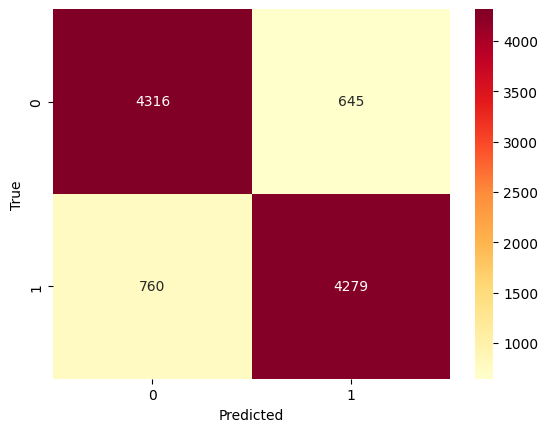

In [ ]:
BN_classifier = MultinomialNB()
BN_classifier.fit(X_train, y_train)

y_pred = BN_classifier.predict(X_test)

f1 = f1_score(y_test, y_pred, pos_label='positivo')
print("F1-score:", f1)

metricas(y_pred,y_test)

##Utilizacion de Cross Validation para los mejores hiperparametros

* Realizaremos una búsqueda de hiperparámetros utilizando validación cruzada para encontrar la mejor configuración del clasificador MultinomialNB. Luego, evaluaremos el modelo con los mejores hiperparámetros utilizando el conjunto de entrenamiento y posteriormente mostraremos el F1 Score y los mejores hiperparámetros encontrados.

F1-score: 0.8623029335461984
              precision    recall  f1-score   support

    negativo       0.86      0.87      0.86      4961
    positivo       0.87      0.86      0.86      5039

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000

Mejores hiperparámetros:
{'alpha': 0.5, 'fit_prior': False}


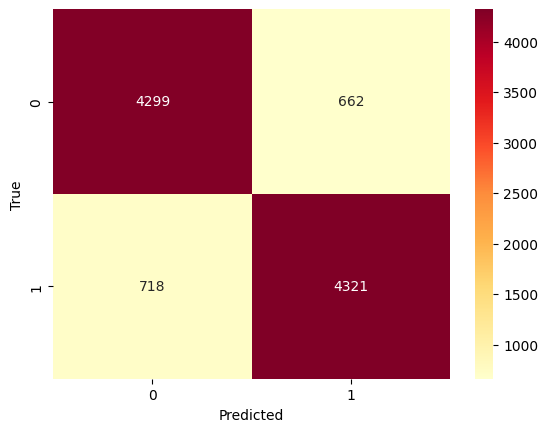

In [ ]:
param_grid = {
    'alpha': [0.1, 0.3, 0.5, 1.0, 1.5, 2.0],
    'fit_prior': [True, False]
}

classifier = MultinomialNB()

grid_search = GridSearchCV(classifier, param_grid, cv=10)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)

f1 = f1_score(y_test, y_pred, pos_label='positivo')
print("F1-score:", f1)

metricas(y_pred,y_test)

print("Mejores hiperparámetros:")
print(best_params)

Exportamos el mejor modelo obtenido segun las métricas obtenidas previamente.

In [ ]:
exportar_BN(best_model, f1)

##Submission clasificador Bayes Naïve

* Hacemos la prediccion con los datos del dataset de test, para luego subir las predicciones obtenidas a la plataforma de Kaggle.

In [ ]:
tfidf_matrix_test = tfidf.transform(criticas_test['preprocessed_text'])
predecir_y_exportar_a_csv_con_BN(best_model, tfidf_matrix_test,f1)

#Clasificador Random Forest


El clasificador Random Forest es una técnica de ensamble que combina múltiples árboles de decisión independientes para realizar predicciones más precisas y robustas. Durante la predicción, cada árbol del bosque genera una predicción individual y la clase final se determina mediante votación o promediado, dependiendo de si es un problema de clasificación o regresión.

* Mostramos como sería el clasificador con los parámetros predeterminados, previamente a buscar los mejores hiperparámetros.

F1-score: 0.8393357342937177
              precision    recall  f1-score   support

    negativo       0.83      0.85      0.84      4961
    positivo       0.85      0.83      0.84      5039

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



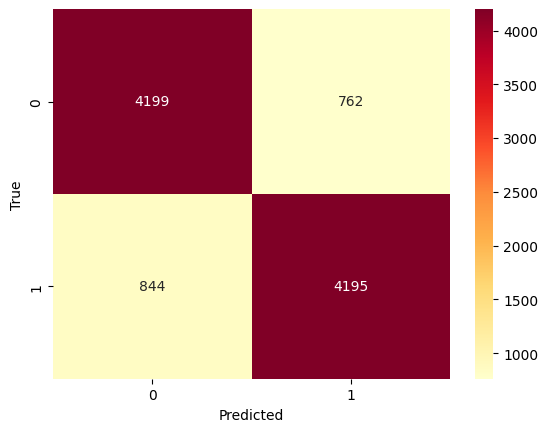

In [ ]:
classifier_rf = RandomForestClassifier()

classifier_rf.fit(X_train, y_train)
y_pred = classifier_rf.predict(X_test)

f1 = f1_score(y_test, y_pred, pos_label='positivo')
print("F1-score:", f1)
metricas(y_pred,y_test)

##Utilizacion de Cross Validation para Random Forest

* Realizaremos una búsqueda de hiperparámetros utilizando validación cruzada para encontrar la mejor configuración del clasificador Random Forest. Luego, evaluaremos el modelo con los mejores hiperparámetros utilizando el conjunto de entrenamiento y posteriormente mostraremos el F1 Score y los mejores hiperparámetros encontrados.

In [ ]:
model = RandomForestClassifier()
param_grid = {
    'max_depth': np.arange(30, 81, 10),
    'min_samples_split': np.arange(7, 10),
    'min_samples_leaf': np.arange(6, 10),
    "n_estimators": list(range(100, 191, 10)),
    'criterion': ['gini', 'entropy']
}

scorer = make_scorer(f1_score)
random_search = RandomizedSearchCV(model, param_distributions=param_grid,scoring=scorer, n_iter=10, cv=10, n_jobs=-1,random_state=42)
random_search.fit(X_train, y_train)

print("Mejores hiperparámetros encontrados:", random_search.best_params_)
y_pred = random_search.predict(X_test)
best_model = random_search.best_estimator_

y_pred = best_model.predict(X_test)
f1 = f1_score(y_test, y_pred, pos_label='positivo')
print("F1-score del mejor modelo:", f1)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Mejores hiperparámetros encontrados: {'n_estimators': 160, 'min_samples_split': 8, 'min_samples_leaf': 7, 'max_depth': 60, 'criterion': 'entropy'}


* Exportamos el mejor modelo obtenido anteriormente

In [ ]:
exportar_RF(best_model, f1)

##Mejor clasificador Random Forest

Cargamos el modelo con los mejores hiperparametros hallados mediante Cross Validation Randomized Search. Evaluaremos dicho modelo y posteriomente mostraremos las respectivas métricas.

In [ ]:
url = 'https://github.com/SabriMendoza/7506R-1C2023-GRUPO33/raw/main/TP02/RF-max_depth_60-min_samples_split_8-min_samples_leaf_7-n_estimators_160-criterion_entropy-f1_0.8476.joblib'

urlretrieve(url, 'RF-max_depth_60-min_samples_split_8-min_samples_leaf_7-n_estimators_160-criterion_entropy-f1_0.8476.joblib')

filename = 'RF-max_depth_60-min_samples_split_8-min_samples_leaf_7-n_estimators_160-criterion_entropy-f1_0.8476.joblib'

best_rf = joblib.load(open(filename, "rb"))

params = best_rf.get_params()
selected_params = {'max_depth': params['max_depth'], 'n_estimators': params['n_estimators'], 'min_samples_split': params['min_samples_split'], 'min_samples_leaf': params['min_samples_leaf'], 'criterion': params['criterion']}
print(f"Parámetros del mejor Random Forest: {selected_params}")

Parámetros del mejor Random Forest: {'max_depth': 60, 'n_estimators': 160, 'min_samples_split': 8, 'min_samples_leaf': 7, 'criterion': 'entropy'}


F1-score: 0.8476088854399069
              precision    recall  f1-score   support

    negativo       0.86      0.82      0.84      4961
    positivo       0.83      0.87      0.85      5039

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



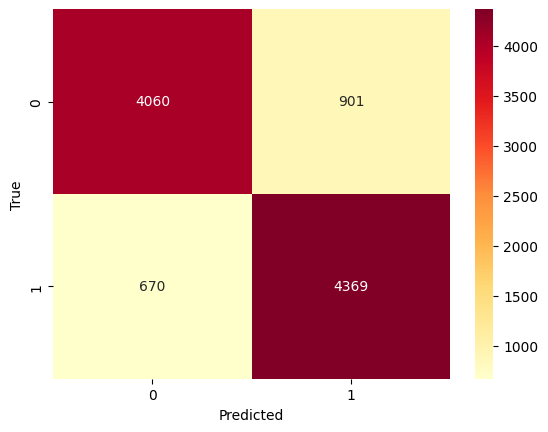

In [ ]:
y_pred = best_rf.predict(X_test)

f1 = f1_score(y_test, y_pred, pos_label='positivo')
print("F1-score:", f1)
metricas(y_pred,y_test)

##Submission clasificador Random Forest

* Hacemos la prediccion con los datos del dataset de test, para luego subir las predicciones obtenidas a la plataforma de Kaggle.

In [ ]:
tfidf_matrix_test = tfidf.transform(criticas_test['preprocessed_text'])
y_pred = best_rf.predict(tfidf_matrix_test)

df_submission = pd.DataFrame({'ID': criticas_test['ID'], 'sentimiento': y_pred})
df_submission.to_csv('submission_RF.csv',index=False)

#Clasificador XGBoost

El método de clasificación XGBoost se basa en la idea de entrenar un conjunto de árboles de decisión de forma secuencial, donde cada árbol se ajusta para corregir los errores cometidos por los árboles anteriores.

* Mostramos como sería el clasificador con los parámetros predeterminados, previamente a buscar los mejores hiperparámetros.

Codificamos las clases del conjunto de entrenamiento, el cual las consideraremos como *0* y *1* en lugar de *positivo* y *negativo*, luego las reconvertiremos para realizar la predicción en Kaggle.

In [ ]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

F1-score: 0.8429141134130922
              precision    recall  f1-score   support

           0       0.85      0.82      0.83      4961
           1       0.83      0.86      0.84      5039

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



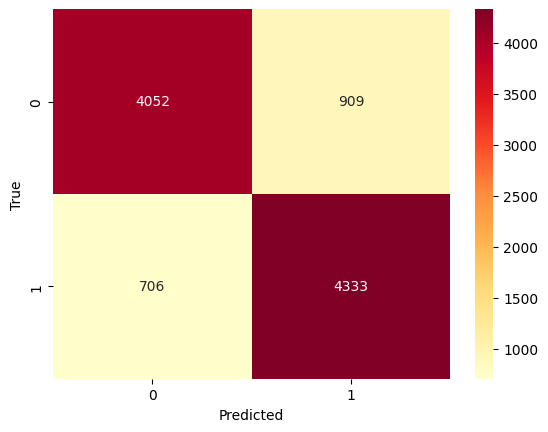

In [ ]:
classifier_xgb = XGBClassifier()

classifier_xgb.fit(X_train, y_train_encoded)
y_pred = classifier_xgb.predict(X_test)

f1=f1_score(y_test_encoded,y_pred)
print("F1-score: "+str(f1))
metricas(y_pred,y_test_encoded)

##Encontrar hiperparametros del clasificador XGBoost

In [ ]:
n=10

params_grid = { "n_estimators": list(range(70, 181, 10)),
                "max_depth": list(range(5,60)),
                'learning_rate': np.arange(0.01, 0.1, 0.01),
                'colsample_bytree': np.arange(0.6, 1.0, 0.1),
              }


folds=5

kfoldcv = StratifiedKFold(n_splits=folds)

xgb = XGBClassifier(objective="binary:logistic", random_state=42, n_jobs=-1)

scorer_fn = make_scorer(f1_score)

randomcv = RandomizedSearchCV(estimator=xgb, param_distributions=params_grid, cv=kfoldcv, scoring=scorer_fn, n_iter=n, random_state=13, n_jobs=-1)

randomcv.fit(X_train, y_train_encoded)

print(f"Mejores hiperparámetros del XGBoost: {randomcv.best_params_}")
print(f"Mejor F1 Score: {randomcv.best_score_}")

Mejores hiperparámetros del XGBoost: {'subsample': 0.7999999999999999, 'reg_lambda': 0.1, 'reg_alpha': 1.0, 'n_estimators': 100, 'max_depth': 17, 'learning_rate': 0.060000000000000005, 'gamma': 0, 'colsample_bytree': 0.6}
Mejor F1 Score: 0.8253052038473804


* Exportamos el mejor modelo obtenido anteriormente

In [ ]:
exportar_XGB(randomcv, randomcv.best_score_)

##Mejor clasificador XGBoost

Creamos y ajustamos el modelo XGBoost con los mejores hiperparametros hallados mediante Cross Validation Randomized Search. Evaluaremos dicho modelo y posteriomente mostraremos las respectivas métricas obtenidas.

In [ ]:
url = 'https://github.com/SabriMendoza/7506R-1C2023-GRUPO33/raw/main/TP02/XGB-n_estimators_160-learning_rate_0.060000000000000005-max_depth_30-f1_0.8458.joblib'

urlretrieve(url, 'XGB-n_estimators_160-learning_rate_0.060000000000000005-max_depth_30-f1_0.8458.joblib')

filename = 'XGB-n_estimators_160-learning_rate_0.060000000000000005-max_depth_30-f1_0.8458.joblib'

best_xgb = joblib.load(open(filename, "rb"))

params = best_xgb.get_params()
selected_params = {'max_depth': params['max_depth'], 'n_estimators': params['n_estimators'], 'learning_rate': params['learning_rate'], 'colsample_bytree': params['colsample_bytree'], 'subsample': params['subsample'], 'eta': params['eta']}
print(f"Parámetros del mejor XGBoost: {selected_params}")

Parámetros del mejor XGBoost: {'max_depth': 30, 'n_estimators': 160, 'learning_rate': 0.060000000000000005, 'colsample_bytree': 0.8, 'subsample': 0.8, 'eta': 0.5}


              precision    recall  f1-score   support

           0       0.85      0.83      0.84      4961
           1       0.84      0.85      0.85      5039

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000

Accuracy: 0.8432
Precision: 0.8383700526418405
Recall: 0.8533439174439373
f1 score: 0.8457907159716759


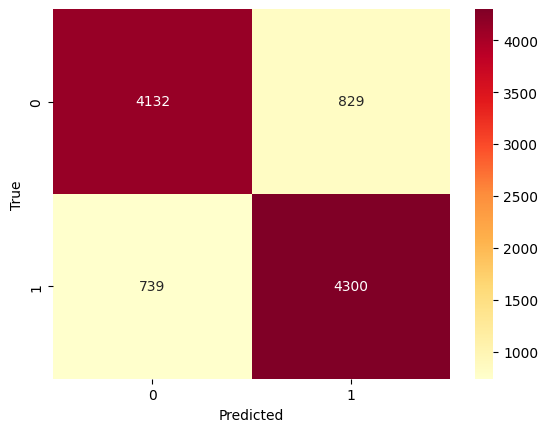

In [ ]:
#Codificamos las clases del conjunto de prueba
y_test_encoded = label_encoder.transform(y_test)

y_pred = best_xgb.predict(X_test)

metricas(y_pred,y_test_encoded)

accuracy=accuracy_score(y_test_encoded,y_pred)
precision=precision_score(y_test_encoded,y_pred)
recall=recall_score(y_test_encoded,y_pred)
f1=f1_score(y_test_encoded,y_pred)

print("Accuracy: "+str(accuracy))
print("Precision: "+str(precision))
print("Recall: "+str(recall))
print("f1 score: "+str(f1))

##Submission clasificador XGBoost

In [ ]:
tfidf_matrix_test = tfidf.transform(criticas_test['preprocessed_text'])
y_pred = best_xgb.predict(tfidf_matrix_test)

print(y_pred)

[0 1 0 ... 0 0 0]


* Los valores correspondientes a la variable *y_pred* corresponden a 0 y 1, por lo que debemos pasarlos a *positivo* o *negativo*.

In [ ]:
label_encoder = LabelEncoder()
clases = ["positivo", "negativo"]
label_encoder.fit(clases)
y_pred_decoded = label_encoder.inverse_transform(y_pred)

print(y_pred_decoded)

['negativo' 'positivo' 'negativo' ... 'negativo' 'negativo' 'negativo']


* Hacemos la prediccion con los datos del dataset de test, para luego subir las predicciones obtenidas a la plataforma de Kaggle.

In [ ]:
df_submission = pd.DataFrame({'ID': criticas_test['ID'], 'sentimiento': y_pred_decoded})
df_submission.to_csv('submission_XGB.csv',index=False)

#Ensamble de modelos

El ensamble de modelos se basa en el principio de que varios modelos diferentes pueden complementarse entre sí y corregir las debilidades individuales de cada uno. Al combinar las predicciones de los modelos individuales, se busca obtener una predicción más precisa y generalizable. En este caso probabermos un ensamble de modelos con modelos que probaremos previamente, sumados a otros clasifiacodores que ayudarán a obtener una mejor calificacion. Estos son LinearSVC (Support Vector Classifier), LogisticRegression (Regresión Logística), SGDClassifier (Stochastic Gradient Descent Classifier).

* LinearSVC es una implementación del clasificador de vectores de soporte lineal. Los clasificadores de vectores de soporte (SVM) son modelos de aprendizaje supervisado que buscan encontrar un hiperplano que separe óptimamente las muestras de diferentes clases en un espacio de características.

F1-score: 0.8948401020207967
              precision    recall  f1-score   support

    negativo       0.90      0.88      0.89      4961
    positivo       0.88      0.91      0.89      5039

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



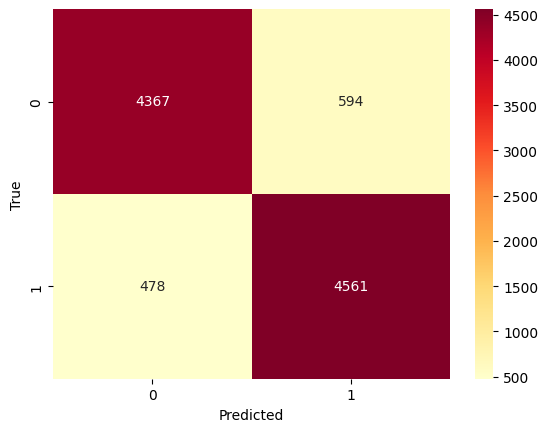

In [ ]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import VotingClassifier

LSVC = LinearSVC( C = 0.2373973042428288, dual = True, loss= 'squared_hinge',  penalty = 'l2')
LSVC.fit(X_train, y_train)
y_pred = LSVC.predict(X_test)

f1 = f1_score(y_test, y_pred, pos_label='positivo')
print("F1-score:", f1)
metricas(y_pred,y_test)

* La Regresión Logística es otro modelo utilizado para problemas de clasificación. Utiliza la función logística para modelar la probabilidad de que una muestra pertenezca a una clase en particular. El objetivo de la regresión logística es encontrar los coeficientes óptimos para los predictores (variables independientes) que maximicen la probabilidad de la clase objetivo.

F1-score: 0.8896072093251054
              precision    recall  f1-score   support

    negativo       0.90      0.87      0.88      4961
    positivo       0.88      0.90      0.89      5039

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



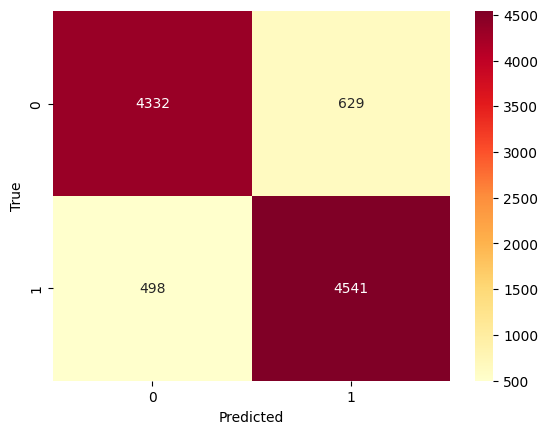

In [ ]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

log_clf = LogisticRegression(max_iter= 1000)
log_clf.fit(X_train, y_train)
y_pred = log_clf.predict(X_test)

f1 = f1_score(y_test, y_pred, pos_label='positivo')
print("F1-score:", f1)
metricas(y_pred,y_test)

* SGDClassifier es un clasificador lineal que utiliza el algoritmo de descenso de gradiente estocástico (SGD) para optimizar la función de pérdida. El descenso de gradiente estocástico es un método de optimización iterativo que se utiliza para encontrar los parámetros que minimizan la función de pérdida.

F1-score: 0.8880226098820777
              precision    recall  f1-score   support

    negativo       0.90      0.87      0.88      4961
    positivo       0.87      0.90      0.89      5039

    accuracy                           0.89     10000
   macro avg       0.89      0.88      0.89     10000
weighted avg       0.89      0.89      0.89     10000



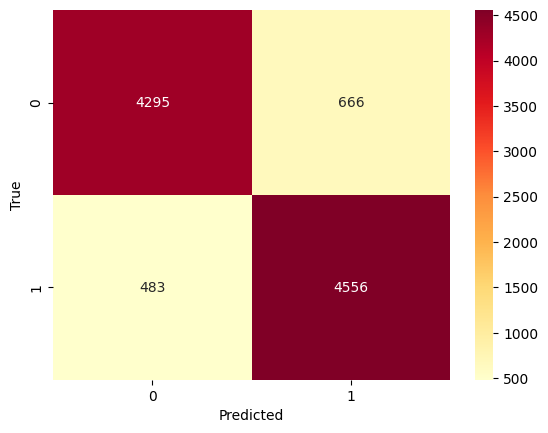

In [ ]:
from sklearn.linear_model import SGDClassifier
SGDC = SGDClassifier()
SGDC.fit(X_train, y_train)
y_pred = SGDC.predict(X_test)

f1 = f1_score(y_test, y_pred, pos_label='positivo')
print("F1-score:", f1)
metricas(y_pred,y_test)

Ahora, probamos diferentes ensambles para crear el ensamble Voting, y nos quedamos con 5 clasificadores tales como LinearSVC, SGDClassifier, LogisticRegression, y los clasificadores de Random Forest y XGBoost  mostrados en apartados anteirores. Luego, entrenamos el ensamble utilizando datos de entrenamiento y realiza predicciones en datos de prueba, evaluando su rendimiento utilizando el puntaje F1.

              precision    recall  f1-score   support

    negativo       0.90      0.87      0.89      4961
    positivo       0.88      0.91      0.89      5039

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000

F1-score: 0.8918654673445444


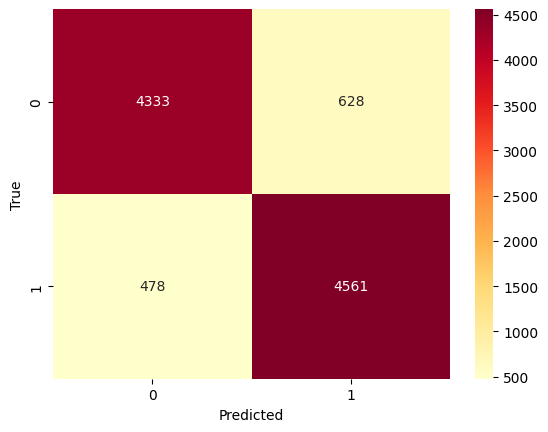

In [ ]:
classifier1 = LSVC
classifier2 = log_clf
classifier3 = SGDC
classifier4 = best_xgb
classifier5 = best_rf

ensamble = VotingClassifier(estimators=[('LSVC', classifier1), ('lr', classifier2), ('SGDC', classifier3), ('xgb', classifier4), ('rf', classifier5)], voting='hard')
ensamble.fit(X_train, y_train)

y_pred = ensamble.predict(X_test)
metricas(y_pred,y_test)

f1 = f1_score(y_test, y_pred, pos_label='positivo')
print("F1-score:", f1)

* Exportamos el modelo entrenado anteriormente

In [ ]:
exportar_ensamble(ensamble, f1)

##Submission ensamble de modelos

In [ ]:
tfidf_matrix_test = tfidf.transform(criticas_test['preprocessed_text'])
y_pred = ensamble.predict(tfidf_matrix_test)

df_submission = pd.DataFrame({'ID': criticas_test['ID'], 'sentimiento': y_pred})
df_submission.to_csv('submission_voting.csv',index=False)

#Redes neuronales aplicando Keras y Tensor Flow


Realizaremos la preparación de los datos para la utilizacion de redes neuronales. Utilizamos la clase Tokenizer de Keras para tokenizar los textos y convertirlos en secuencias numéricas. Luego determinamos la longitud máxima de una secuencia en el conjunto de entrenamiento y utilizamos la función pad_sequences para rellenar las secuencias y asegurarnos de que todas tengan la misma longitud.


In [ ]:
textos = criticas["review_es"]
etiquetas = criticas["sentimiento"]

le = LabelEncoder()
etiquetas_codificadas = le.fit_transform(etiquetas)

textos_entrenamiento, textos_prueba, etiquetas_entrenamiento, etiquetas_prueba = train_test_split(
    textos, etiquetas_codificadas, test_size=0.3, random_state=42)

tokenizer = Tokenizer(num_words = 1000)
tokenizer.fit_on_texts(textos_entrenamiento)

secuencias_entrenamiento = tokenizer.texts_to_sequences(textos_entrenamiento)
secuencias_prueba = tokenizer.texts_to_sequences(textos_prueba)

longitud_maxima = max(len(seq) for seq in secuencias_entrenamiento)

secuencias_entrenamiento = pad_sequences(secuencias_entrenamiento, maxlen=longitud_maxima)
secuencias_prueba = pad_sequences(secuencias_prueba, maxlen=longitud_maxima)

##Dataframe test

Aplicamos el mismo preprocesamiento en el conjunto de los datos del dataset con los datos de test. Es decir, sobre el que haremos las predicciones de nuestros modelos.

In [ ]:
textos_test = criticas_test['review_es']

secuencias_test = tokenizer.texts_to_sequences(textos_test)
secuencias_test = pad_sequences(secuencias_test, maxlen=longitud_maxima)

##Modelo 1

* Utilizamos una capa de Embedding, una capa LSTM y una capa Dense. Para el entrenamiento del mismo decidimos seleccionar 5 epochs y un tamaño de batch_size de 100.
* Puntuación de pérdida: 0.35149 y F1-score: 0.85754

In [ ]:
modelo = Sequential()
modelo.add(Embedding(len(tokenizer.word_index) + 1, 100, input_length=longitud_maxima))
modelo.add(LSTM(100))
modelo.add(Dense(1, activation='sigmoid'))

modelo.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1031, 100)         16037900  
                                                                 
 lstm (LSTM)                 (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 16,118,401
Trainable params: 16,118,401
Non-trainable params: 0
_________________________________________________________________


In [ ]:
modelo.compile(loss='binary_crossentropy', optimizer='adam', metrics=[f1_score_metric])
modelo.fit(secuencias_entrenamiento, etiquetas_entrenamiento, validation_data=(secuencias_prueba, etiquetas_prueba), epochs=5, batch_size=100)

resultados = modelo.evaluate(secuencias_prueba, etiquetas_prueba, batch_size=100)
print("Puntuación de pérdida:", resultados[0])
print("F1-score:", resultados[1])

Epoch 1/5
350/350 [==============================] - 1256s 4s/step - loss: 0.4614 - f1_score_metric: 0.7856 - val_loss: 0.3816 - val_f1_score_metric: 0.8502
Epoch 2/5
350/350 [==============================] - 1213s 3s/step - loss: 0.3610 - f1_score_metric: 0.8406 - val_loss: 0.3674 - val_f1_score_metric: 0.8466
Epoch 3/5
350/350 [==============================] - 1235s 4s/step - loss: 0.3432 - f1_score_metric: 0.8494 - val_loss: 0.3466 - val_f1_score_metric: 0.8566
Epoch 4/5
350/350 [==============================] - 1248s 4s/step - loss: 0.3377 - f1_score_metric: 0.8542 - val_loss: 0.3565 - val_f1_score_metric: 0.8427
Epoch 5/5
150/150 [==============================] - 136s 902ms/step - loss: 0.3515 - f1_score_metric: 0.8575
Puntuación de pérdida: 0.35149866342544556
F1-score: 0.8575493097305298


* Realizar predicciones en el conjunto de test

In [ ]:
predicciones_test = modelo.predict(secuencias_test)
predicciones_binarias_test = [round(pred[0]) for pred in predicciones_test]

etiquetas_prediccion = ['negativo' if pred == 0 else 'positivo' for pred in predicciones_binarias_test]
df_submission = pd.DataFrame({'ID': criticas_test['ID'], 'sentimiento': etiquetas_prediccion})

df_submission.to_csv('submission_RN.csv', index=False)

269/269 [==============================] - 72s 261ms/step


##Modelo 2

* Utilizamos una capa de Embedding, pero ahora 2 capas LSTM y una capa Dense. Para el entrenamiento del mismo decidimos seleccionar 5 epochs y un tamaño de batch_size de 64. Notamos que no hubo una gran diferencia con respecto al F1-Score.

* Puntuación de pérdida: 0.353068 y F1-score: 0.85565

In [ ]:
modelo2 = Sequential()
modelo2.add(Embedding(len(tokenizer.word_index) + 1, 50, input_length=longitud_maxima))
modelo2.add(LSTM(64, return_sequences=True))
modelo2.add(LSTM(64))
modelo2.add(Dense(1, activation='sigmoid'))

modelo2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1031, 50)          8018950   
                                                                 
 lstm (LSTM)                 (None, 1031, 64)          29440     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 8,081,479
Trainable params: 8,081,479
Non-trainable params: 0
_________________________________________________________________


In [ ]:
modelo2.compile(loss='binary_crossentropy', optimizer='adam', metrics=[f1_score_metric])

epochs = 5
batch_size = 64

modelo2.fit(secuencias_entrenamiento, etiquetas_entrenamiento, validation_data=(secuencias_prueba, etiquetas_prueba), epochs=epochs, batch_size=batch_size)

resultados_modelo2 = modelo2.evaluate(secuencias_prueba, etiquetas_prueba, batch_size=batch_size)
print("Puntuación de pérdida:", resultados_modelo2[0])
print("F1-score:", resultados_modelo2[1])

Epoch 1/5
547/547 [==============================] - 1161s 2s/step - loss: 0.4924 - f1_score_metric: 0.7368 - val_loss: 0.4626 - val_f1_score_metric: 0.7985
Epoch 2/5
547/547 [==============================] - 1153s 2s/step - loss: 0.4469 - f1_score_metric: 0.7965 - val_loss: 0.3662 - val_f1_score_metric: 0.8369
Epoch 3/5
547/547 [==============================] - 1162s 2s/step - loss: 0.3635 - f1_score_metric: 0.8398 - val_loss: 0.3650 - val_f1_score_metric: 0.8443
Epoch 4/5
547/547 [==============================] - 1163s 2s/step - loss: 0.3710 - f1_score_metric: 0.8393 - val_loss: 0.3707 - val_f1_score_metric: 0.8428
Epoch 5/5
235/235 [==============================] - 113s 481ms/step - loss: 0.3517 - f1_score_metric: 0.8533
Puntuación de pérdida: 0.3516623079776764
F1-score: 0.8533214330673218


469/469 [==============================] - 142s 300ms/step
              precision    recall  f1-score   support

           0       0.87      0.82      0.84      7411
           1       0.83      0.88      0.85      7589

    accuracy                           0.85     15000
   macro avg       0.85      0.85      0.85     15000
weighted avg       0.85      0.85      0.85     15000



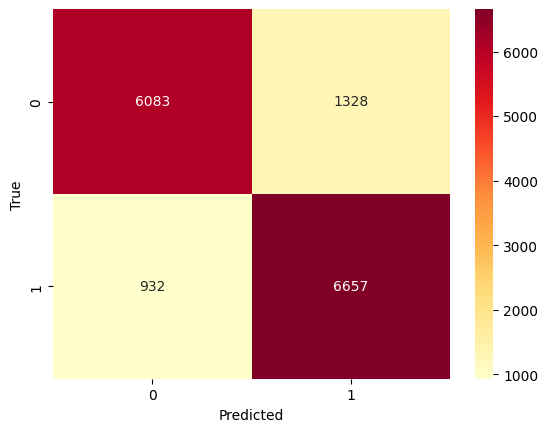

In [ ]:
y_pred = modelo2.predict(secuencias_prueba)
y_pred = (y_pred > 0.5).astype(int)

metricas(y_pred, etiquetas_prueba)

* Realizar predicciones en el conjunto de test

In [ ]:
predicciones_test = modelo2.predict(secuencias_test)
predicciones_binarias_test = [round(pred[0]) for pred in predicciones_test]

etiquetas_prediccion = ['negativo' if pred == 0 else 'positivo' for pred in predicciones_binarias_test]
df_submission = pd.DataFrame({'ID': criticas_test['ID'], 'sentimiento': etiquetas_prediccion})

df_submission.to_csv('submission_RN2.csv', index=False)

269/269 [==============================] - 80s 298ms/step


##Modelo 3

* Este modelo es similar al modelo 2, pero en este caso decidimos utilizar dos capas dense en lugar de 2 capas LSTM. No hubo diferencia con respecto al F1-Score obtenido.

* Puntuación de pérdida: 0.34394 y F1-score: 0.85514

In [ ]:
modelo3 = Sequential()
modelo3.add(Embedding(len(tokenizer.word_index) + 1, 50, input_length=longitud_maxima))
modelo3.add(LSTM(64))
modelo3.add(Dense(32, activation='relu'))
modelo3.add(Dense(1, activation='sigmoid'))

modelo3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 1031, 50)          8018950   
                                                                 
 lstm_3 (LSTM)               (None, 64)                29440     
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 8,050,503
Trainable params: 8,050,503
Non-trainable params: 0
_________________________________________________________________


In [ ]:
modelo3.compile(loss='binary_crossentropy', optimizer='adam', metrics=[f1_score_metric])

epochs = 5
batch_size = 64
modelo3.fit(secuencias_entrenamiento, etiquetas_entrenamiento, validation_data=(secuencias_prueba, etiquetas_prueba), epochs=epochs, batch_size=batch_size)

resultados_modelo3 = modelo3.evaluate(secuencias_prueba, etiquetas_prueba, batch_size=batch_size)
print("Puntuación de pérdida:", resultados_modelo3[0])
print("F1-score:", resultados_modelo3[1])

Epoch 1/5
547/547 [==============================] - 667s 1s/step - loss: 0.4382 - f1_score_metric: 0.7857 - val_loss: 0.3726 - val_f1_score_metric: 0.8400
Epoch 2/5
547/547 [==============================] - 600s 1s/step - loss: 0.3630 - f1_score_metric: 0.8384 - val_loss: 0.4119 - val_f1_score_metric: 0.8395
Epoch 3/5
547/547 [==============================] - 599s 1s/step - loss: 0.3455 - f1_score_metric: 0.8493 - val_loss: 0.3347 - val_f1_score_metric: 0.8547
Epoch 4/5
547/547 [==============================] - 600s 1s/step - loss: 0.3260 - f1_score_metric: 0.8564 - val_loss: 0.3528 - val_f1_score_metric: 0.8555
Epoch 5/5
235/235 [==============================] - 56s 237ms/step - loss: 0.3439 - f1_score_metric: 0.8551
Puntuación de pérdida: 0.3439454436302185
F1-score: 0.855144202709198


469/469 [==============================] - 69s 147ms/step
              precision    recall  f1-score   support

           0       0.88      0.81      0.84      7411
           1       0.83      0.89      0.86      7589

    accuracy                           0.85     15000
   macro avg       0.85      0.85      0.85     15000
weighted avg       0.85      0.85      0.85     15000



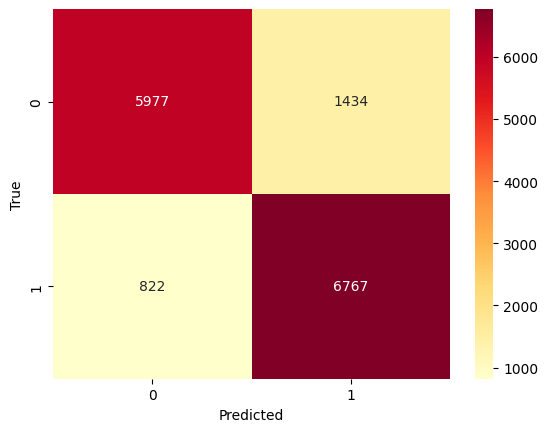

In [ ]:
y_pred = modelo3.predict(secuencias_prueba)
y_pred = (y_pred > 0.5).astype(int)

metricas(y_pred, etiquetas_prueba)

* Realizar predicciones en el conjunto de test

In [ ]:
predicciones_test = modelo3.predict(secuencias_test)
predicciones_binarias_test = [round(pred[0]) for pred in predicciones_test]

etiquetas_prediccion = ['negativo' if pred == 0 else 'positivo' for pred in predicciones_binarias_test]
df_submission = pd.DataFrame({'ID': criticas_test['ID'], 'sentimiento': etiquetas_prediccion})

df_submission.to_csv('submission_RN3.csv', index=False)

269/269 [==============================] - 45s 166ms/step


##Modelo 4

* En este modelo utilizamos una capa embedding, LSTM, Dropout y dense.

* Puntuación de pérdida: 0.374931 y F1-score: 0.84700

In [ ]:
modelo4 = Sequential()
modelo4.add(Embedding(len(tokenizer.word_index) + 1, 50, input_length=longitud_maxima))
modelo4.add(LSTM(64))
modelo4.add(Dropout(0.2))
modelo4.add(Dense(1, activation='sigmoid'))

modelo4.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 1031, 50)          8018950   
                                                                 
 lstm_5 (LSTM)               (None, 64)                29440     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 8,048,455
Trainable params: 8,048,455
Non-trainable params: 0
_________________________________________________________________


In [ ]:
modelo4.compile(loss='binary_crossentropy', optimizer='adam', metrics=[f1_score_metric])

epochs = 5
batch_size = 30

modelo4.fit(secuencias_entrenamiento, etiquetas_entrenamiento, validation_data=(secuencias_prueba, etiquetas_prueba), epochs=epochs, batch_size=batch_size)

resultados_modelo4 = modelo4.evaluate(secuencias_prueba, etiquetas_prueba, batch_size=batch_size)
print("Puntuación de pérdida:", resultados_modelo4[0])
print("F1-score:", resultados_modelo4[1])

Epoch 1/5
1167/1167 [==============================] - 989s 845ms/step - loss: 0.4378 - f1_score_metric: 0.7967 - val_loss: 0.4294 - val_f1_score_metric: 0.8041
Epoch 2/5
1167/1167 [==============================] - 991s 849ms/step - loss: 0.3782 - f1_score_metric: 0.8339 - val_loss: 0.3660 - val_f1_score_metric: 0.8485
Epoch 3/5
1167/1167 [==============================] - 989s 847ms/step - loss: 0.3555 - f1_score_metric: 0.8423 - val_loss: 0.3488 - val_f1_score_metric: 0.8425
Epoch 4/5
1167/1167 [==============================] - 987s 846ms/step - loss: 0.3466 - f1_score_metric: 0.8479 - val_loss: 0.3564 - val_f1_score_metric: 0.8487
Epoch 5/5
500/500 [==============================] - 74s 147ms/step - loss: 0.3749 - f1_score_metric: 0.8470
Puntuación de pérdida: 0.3749314844608307
F1-score: 0.8470072746276855


469/469 [==============================] - 72s 152ms/step
              precision    recall  f1-score   support

           0       0.89      0.76      0.82      7411
           1       0.80      0.91      0.85      7589

    accuracy                           0.84     15000
   macro avg       0.85      0.84      0.84     15000
weighted avg       0.85      0.84      0.84     15000



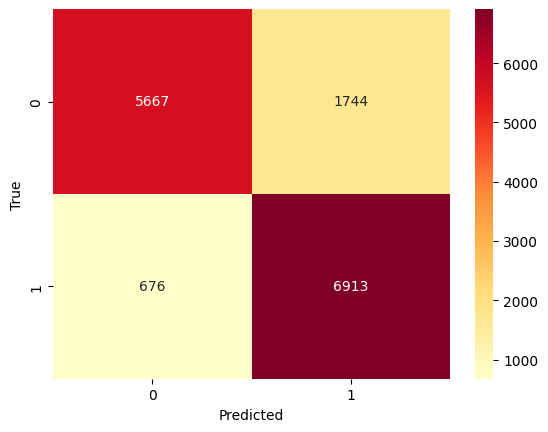

In [ ]:
y_pred = modelo4.predict(secuencias_prueba)
y_pred = (y_pred > 0.5).astype(int)

metricas(y_pred, etiquetas_prueba)

A pesar de haber utilizado una menor cantidad de batch size (30) fue el que peor metrica de F1-Score nos dió.

* Realizar predicciones en el conjunto de test

In [ ]:
predicciones_test = modelo4.predict(secuencias_test)
predicciones_binarias_test = [round(pred[0]) for pred in predicciones_test]

etiquetas_prediccion = ['negativo' if pred == 0 else 'positivo' for pred in predicciones_binarias_test]
df_submission = pd.DataFrame({'ID': criticas_test['ID'], 'sentimiento': etiquetas_prediccion})

df_submission.to_csv('submission_RN4.csv', index=False)

269/269 [==============================] - 47s 174ms/step


##Modelo 5

* Para este modelo, decidimos incrementar el numero de capas. Utilizamos una capa embedding, 3 capas LSTM, 2 capas dense. Ademas, incrementamos el batch size a 100, lo que nos permitió obtener el mejor F1-Score entre los modelos previamente entrenados.

* Puntuación de pérdida: 0.339096 y F1-score: 0.85966

In [ ]:
modelo5 = Sequential()
modelo5.add(Embedding(len(tokenizer.word_index) + 1, 100, input_length=longitud_maxima))
modelo5.add(LSTM(50, return_sequences=True))
modelo5.add(LSTM(50, return_sequences=True))
modelo5.add(LSTM(50))
modelo5.add(Dense(32, activation='relu'))
modelo5.add(Dense(1, activation='sigmoid'))

modelo5.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1031, 100)         16037900  
                                                                 
 lstm (LSTM)                 (None, 1031, 50)          30200     
                                                                 
 lstm_1 (LSTM)               (None, 1031, 50)          20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 32)                1632      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 16,110,165
Trainable params: 16,110,165
No

In [ ]:
modelo5.compile(loss='binary_crossentropy', optimizer='adam', metrics=[f1_score_metric])

epochs = 5
batch_size = 100

modelo5.fit(secuencias_entrenamiento, etiquetas_entrenamiento, validation_data=(secuencias_prueba, etiquetas_prueba), epochs=epochs, batch_size=batch_size)

resultados = modelo5.evaluate(secuencias_prueba, etiquetas_prueba, batch_size=batch_size)
print("Puntuación de pérdida:", resultados[0])
print("F1-score:", resultados[1])

Epoch 1/5
350/350 [==============================] - 1476s 4s/step - loss: 0.4561 - f1_score_metric: 0.7603 - val_loss: 0.3552 - val_f1_score_metric: 0.8427
Epoch 2/5
350/350 [==============================] - 1485s 4s/step - loss: 0.3587 - f1_score_metric: 0.8436 - val_loss: 0.3480 - val_f1_score_metric: 0.8528
Epoch 3/5
350/350 [==============================] - 1483s 4s/step - loss: 0.3437 - f1_score_metric: 0.8521 - val_loss: 0.3653 - val_f1_score_metric: 0.8310
Epoch 4/5
350/350 [==============================] - 1496s 4s/step - loss: 0.3210 - f1_score_metric: 0.8611 - val_loss: 0.3479 - val_f1_score_metric: 0.8556
Epoch 5/5
150/150 [==============================] - 168s 1s/step - loss: 0.3391 - f1_score_metric: 0.8597
Puntuación de pérdida: 0.33909639716148376
F1-score: 0.8596614599227905


469/469 [==============================] - 218s 463ms/step
              precision    recall  f1-score   support

           0       0.88      0.82      0.85      7411
           1       0.84      0.89      0.86      7589

    accuracy                           0.85     15000
   macro avg       0.86      0.85      0.85     15000
weighted avg       0.86      0.85      0.85     15000



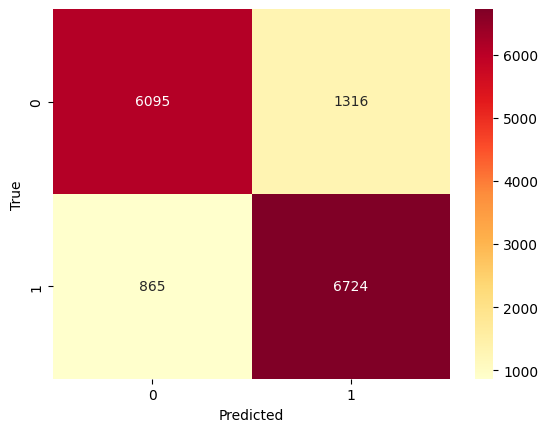

In [ ]:
y_pred = modelo5.predict(secuencias_prueba)
y_pred = (y_pred > 0.5).astype(int)

metricas(y_pred, etiquetas_prueba)

* Realizar predicciones en el conjunto de test

In [ ]:
predicciones_test = modelo5.predict(secuencias_test)
predicciones_binarias_test = [round(pred[0]) for pred in predicciones_test]

etiquetas_prediccion = ['negativo' if pred == 0 else 'positivo' for pred in predicciones_binarias_test]
df_submission = pd.DataFrame({'ID': criticas_test['ID'], 'sentimiento': etiquetas_prediccion})

df_submission.to_csv('submission_RN5.csv', index=False)

269/269 [==============================] - 124s 461ms/step


##Mejor modelo de red neuronal

* Luego de entrenar con barias capas, decidimos modificar el modelo anterior, con la utilizacion de dos capas bidriectional en lugar de 3 capas LSTM, y reducuendo el batch_size a 50. Esto nos permitió mejorar las métricas en el conjunto de entrenamiento, y además logramos mejorar considerablemente el puntaje público en la plataforma de Kaggle.

* Puntuación de pérdida: 0.345386 y F1-score: 0.85972

In [ ]:
modelo6 = Sequential()
modelo6.add(Embedding(len(tokenizer.word_index) + 1, 50, input_length=longitud_maxima))
modelo6.add(Bidirectional(LSTM(25, return_sequences=True)))
modelo6.add(Bidirectional(LSTM(25)))
modelo6.add(Dense(16, activation='relu'))
modelo6.add(Dense(1, activation='sigmoid'))

modelo6.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 1031, 50)          8018950   
                                                                 
 bidirectional_2 (Bidirectio  (None, 1031, 50)         15200     
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 50)               15200     
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 16)                816       
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 8,050,183
Trainable params: 8,050,183
No

In [ ]:
modelo6.compile(loss='binary_crossentropy', optimizer='adam', metrics=[f1_score_metric])

epochs = 5
batch_size = 50

modelo6.fit(secuencias_entrenamiento, etiquetas_entrenamiento, validation_data=(secuencias_prueba, etiquetas_prueba), epochs=epochs, batch_size=batch_size)

resultados_modelo6 = modelo6.evaluate(secuencias_prueba, etiquetas_prueba, batch_size=batch_size)
print("Puntuación de pérdida:", resultados_modelo6[0])
print("F1-score:", resultados_modelo6[1])

Epoch 1/5
700/700 [==============================] - 1496s 2s/step - loss: 0.4468 - f1_score_metric: 0.7953 - val_loss: 0.4338 - val_f1_score_metric: 0.7901
Epoch 2/5
700/700 [==============================] - 1481s 2s/step - loss: 0.3544 - f1_score_metric: 0.8450 - val_loss: 0.3635 - val_f1_score_metric: 0.8308
Epoch 3/5
700/700 [==============================] - 1447s 2s/step - loss: 0.3334 - f1_score_metric: 0.8559 - val_loss: 0.3498 - val_f1_score_metric: 0.8541
Epoch 4/5
700/700 [==============================] - 1452s 2s/step - loss: 0.3184 - f1_score_metric: 0.8636 - val_loss: 0.3630 - val_f1_score_metric: 0.8334
Epoch 5/5
300/300 [==============================] - 123s 411ms/step - loss: 0.3454 - f1_score_metric: 0.8597
Puntuación de pérdida: 0.34538623690605164
F1-score: 0.8597233891487122


469/469 [==============================] - 213s 451ms/step
              precision    recall  f1-score   support

           0       0.90      0.78      0.84      7411
           1       0.81      0.92      0.86      7589

    accuracy                           0.85     15000
   macro avg       0.86      0.85      0.85     15000
weighted avg       0.86      0.85      0.85     15000



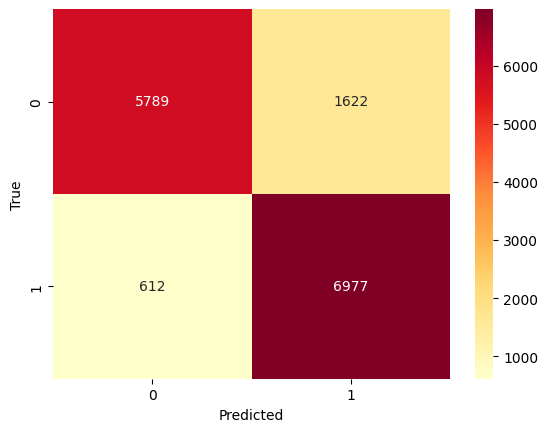

In [ ]:
y_pred = modelo6.predict(secuencias_prueba)
y_pred = (y_pred > 0.5).astype(int)

metricas(y_pred, etiquetas_prueba)

* Realizar predicciones en el conjunto de test

In [ ]:
predicciones_test = modelo6.predict(secuencias_test)
predicciones_binarias_test = [round(pred[0]) for pred in predicciones_test]

etiquetas_prediccion = ['negativo' if pred == 0 else 'positivo' for pred in predicciones_binarias_test]
df_submission = pd.DataFrame({'ID': criticas_test['ID'], 'sentimiento': etiquetas_prediccion})

df_submission.to_csv('submission_RN6.csv', index=False)

269/269 [==============================] - 99s 369ms/step


* Exportamos el mejor modelo de red neuronal.

In [ ]:
joblib.dump(modelo6, f'Red-neuronal-embedding-2_bidirectional-2_dense-f1_0.859723.joblib')

['Red-neuronal-embedding-2_bidirectional-2_dense-f1_0.859723.joblib']